# Trotter systematic error - Hubbard on the square lattice 

In this example we use the [pyALF](https://git.physik.uni-wuerzburg.de/ALF/pyALF) interface to run ALF with the Mz choice of Hubbard-Stratonovich transformation (i.e., coupled to the $z$-component of the spin) on a $6\times 6$ site square lattice, at $U/t=4$ half-band filling, and inverse temperature $\beta t = 5$.

We carry out a systematic $\Delta \tau  t$ extrapolation keeping    $\Delta \tau t  L_\text{Trotter} = 2$  constant. Recall that  the formulation of the auxiliary field QMC approach is based on the symmetric Trotter decomposition 
$$
e^{ -\Delta \tau \left( \hat{A} + \hat{B} \right) }  =  e^{ -\Delta \tau \hat{A}/2}  e^{ -\Delta \tau  \hat{B}  }   e^{ -\Delta \tau \hat{A}/2}  +  \mathcal{O} \left (\Delta  \tau^3\right)
$$
The overall error produced by this approximation is of the order $\Delta \tau^2$.  

Bellow we go through the steps for performing this extrapolation: setting the simulation parameters, running it and analysing the data. A reference plot for this analyses is found in [ALF documentation](https://git.physik.uni-wuerzburg.de/ALF/ALF/-/blob/master/Documentation/doc.pdf), Sec. 2.3.2 (Symmetric Trotter decomposition).

---

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF, as well as mathematics and plotting packages:

In [1]:
from py_alf import ALF_source, Simulation # Interface with ALF
# 
import numpy as np                        # Numerical library
from scipy.optimize import curve_fit      # Numerical library
import matplotlib.pyplot as plt           # Plotting library
alf_src = ALF_source(
    branch='196-write-parameters-to-hdf5-file', # TODO: Remove this after merging '196-write-parameters-to-hdf5-file' into master
)

Checking out branch 196-write-parameters-to-hdf5-file


**2.** Create instances of `Simulation`, specifying the necessary parameters, in particular the different $\Delta \tau$ values:

In [2]:
sims = []                                # Vector of Simulation instances
print('dtau values used:')
for dtau in [0.05, 0.1, 0.2]:            # Values of dtau
    print(dtau)
    sim = Simulation(
        alf_src,
        'Hubbard',                       # Hamiltonian
        {                                # Model and simulation parameters for each Simulation instance
        'Model': 'Hubbard',              #    Base model
        'Lattice_type': 'Square',        #    Lattice type
        'L1': 6,                         #    Lattice length in the first unit vector direction
        'L2': 6,                         #    Lattice length in the second unit vector direction
        'Checkerboard': False,           #    Whether checkerboard decomposition is used or not
        'Symm': True,                    #    Whether symmetrization takes place
        'ham_T': 1.0,                    #    Hopping parameter
        'ham_U': 4.0,                    #    Hubbard interaction
        'ham_Tperp': 0.0,                #    For bilayer systems
        'beta': 5.0,                     #    Inverse temperature
        'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
        'NSweep': 200,                   #    Number of sweeps per bin
        'NBin': 10,                      #    Number of bins
        'Dtau': dtau,                    #    Only dtau varies between simulations, Ltrot=beta/Dtau
        'Mz': True,                      #    If true, sets the M_z-Hubbard model: Nf=2, N_sum=1,
        },                               #             HS field couples to z-component of magnetization
    )
    sims.append(sim)

dtau values used:
0.05
0.1
0.2


**3.** Compile ALF, downloading it first if not found locally. This may take a few minutes:

In [3]:
sims[0].compile()                        # Compilation needs to be performed only once

Compiling ALF... 
Done.


**4.** Perform the simulations, as specified in each element of `sim`:

In [4]:
for i, sim in enumerate(sims):
    sim.run()                            # Perform the actual simulation in ALF

Prepare directory "/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/ALF/ALF/Prog/ALF.out
Prepare directory "/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.1_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/ALF/ALF/Prog/ALF.out
Prepare directory "/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.2_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/ALF/ALF/Prog/ALF.out


**5.** Calculate the internal energies:

In [5]:
ener = np.empty((len(sims), 2))          # Matrix for storing energy values
dtaus = np.empty((len(sims),))           # Matrix for Dtau values, for plotting
for i, sim in enumerate(sims):
    print(sim.sim_dir)                   # Directory containing the simulation output
    sim.analysis()                       # Perform default analysis
    dtaus[i] = sim.sim_dict['Dtau']      # Store Dtau value
    obs = sim.get_obs()
    ener[i] = obs.iloc[0][['Ener_scal0', 'Ener_scal0_err']]  # Store energy value

/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True
### Analyzing /home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True ###
/home/stafusa/ALF/pyALF/Notebooks
Custom observables:
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True
/home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.1_Mz=True
### Analyzing /home/stafusa/ALF/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.1_Mz=True ###
/home

In [6]:
print('For Dtau values', dtaus, 'the measured energies are:\n', ener)

For Dtau values [0.05 0.1  0.2 ] the measured energies are:
 [[-29.74357897   0.05859309]
 [-29.76641031   0.04718618]
 [-29.82861261   0.04164235]]


[-29.74167788  -2.18460779] [0.04509681 1.66225714]


<ErrorbarContainer object of 3 artists>

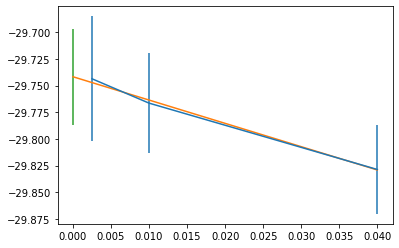

In [7]:
plt.errorbar(dtaus**2, ener[:, 0], ener[:, 1])

def func(x, y0, a):
    return y0 + a*x**2
popt1, pcov = curve_fit(func, dtaus, ener[:, 0], sigma=ener[:, 1], absolute_sigma=True)
perr1 = np.sqrt(np.diag(pcov))
print(popt1, perr1)
xs = np.linspace(0., dtaus.max())
plt.plot(xs**2, func(xs, *popt1))

plt.errorbar(0, popt1[0], perr1[0])

---
## Exercises
1. Try out the four different combinations for `Checkerboard` and `Symm` settings in order to observe their effect on the output and run time. Reference: Sec. 2.3.2 - Symmetric Trotter decomposition - of the [ALF documentation](https://git.physik.uni-wuerzburg.de/ALF/ALF/-/blob/master/Documentation/doc.pdf), especially Fig. 2.